In [53]:
import os
import time
import numpy as np
import pandas as pd
import nltk
import string
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from nltk.stem.snowball import EnglishStemmer

In [2]:
data = pd.read_csv("data/flipkart_com-ecommerce_sample_1050.csv")
data = data.set_index('uniq_id')

In [3]:
data.head()

,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
uniq_id,,,,,,,,,,,,,,
55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."


In [4]:
from functions import *
isnan(data)

La colonne 'retail_price' comporte 1 / 1050 valeur(s) manquante(s)
Ce qui représente 0.09523809523809523%
La colonne 'discounted_price' comporte 1 / 1050 valeur(s) manquante(s)
Ce qui représente 0.09523809523809523%
La colonne 'brand' comporte 338 / 1050 valeur(s) manquante(s)
Ce qui représente 32.19047619047619%
La colonne 'product_specifications' comporte 1 / 1050 valeur(s) manquante(s)
Ce qui représente 0.09523809523809523%
4 colonnes au total possèdent des valeurs manquantes
85.25 / 1050 valeurs sont manquantes en moyenne dans chaque colonne


# Categories

In [5]:
# We first need to extract the categories from the data
data['categ'] = data['product_category_tree'].str.split(pat='>>').str[0]
data['categ'] = data['categ'].str.split(pat='"').str[1]
# Let's get the second categ, we'll see if we need it later
data['categ2'] = data['product_category_tree'].str.split(pat='>>').str[1]

In [6]:
len(data['categ'].unique())

7

In [7]:
len(data)

1050

In [8]:
count_categ = data.groupby('categ').count()['pid'] # Take whatever column to count
count_categ

categ
Baby Care                      150
Beauty and Personal Care       150
Computers                      150
Home Decor & Festive Needs     150
Home Furnishing                150
Kitchen & Dining               150
Watches                        150
Name: pid, dtype: int64

# Products

In [9]:
len(data['product_name'].unique())

1050

# Description analysis

## Normalisation

In [10]:
data_text = data.reset_index()
data_text = data_text[['categ', 'description']]
# We take one line per category and sum the description
data_text = data_text.groupby('categ').sum()
# We'll need to change that later, not the best practice

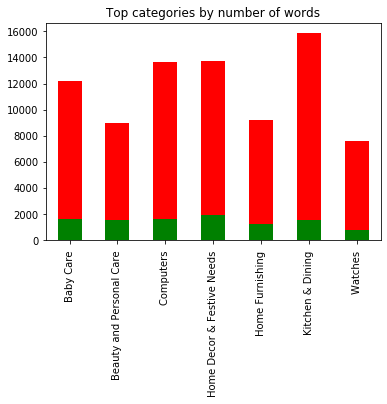

In [11]:
# The goal here is to extract the frequences of the words
# And also to extract the frequences of unique words
tokenizer = nltk.RegexpTokenizer(r'\w+')

desc = defaultdict(list)

for i in data_text.index:
    desc[i] += tokenizer.tokenize(data_text.loc[i, 'description'].lower())

stats, freq = dict(), dict()

for k, v in zip(desc.keys(), desc.values()):
    freq[k] = fq = nltk.FreqDist(v)
    stats[k] = {'total': len(v), 'Unique': len(fq.keys())} 

df = pd.DataFrame.from_dict(stats, orient='index')

# freq display
df.sort_values(by='total', ascending=False)
df['total'].plot(kind='bar', color="red", title='Top categories by number of words', label='Total')
df['Unique'].plot(kind='bar', color="green", label='Unique')
plt.show()

## Stop words

Let's work on the stop words ; We will create our own set of stop words and then add a common list to that

In [12]:
# First we get the freq of words on our dataset
freq_totale = nltk.Counter()
for k, v in zip(desc.keys(), desc.values()):
    freq_totale += freq[k]

# Here is our list of stop words
most_freq = { key:value for (key,value) in freq_totale.items() if value >= 100}.keys()

# Let's add the common stop words list of nltk
sw = set()
sw.update(most_freq)
sw.update(tuple(nltk.corpus.stopwords.words('english')))

Let's plot again our words repartition but without the stop words this time

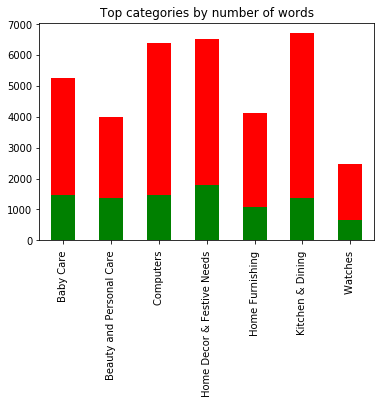

In [13]:
tokenizer = nltk.RegexpTokenizer(r'\w+')

desc = defaultdict(list)

for i in data_text.index:
    token = tokenizer.tokenize(data_text.loc[i, 'description'].lower())
    desc[i] += [w for w in token if not w in list(sw)]

stats, freq = dict(), dict()

for k, v in zip(desc.keys(), desc.values()):
    freq[k] = fq = nltk.FreqDist(v)
    stats[k] = {'total': len(v), 'Unique': len(fq.keys())} 

df = pd.DataFrame.from_dict(stats, orient='index')

# freq display
df.sort_values(by='total', ascending=False)
df['total'].plot(kind='bar', color="red", title='Top categories by number of words', label='Total')
df['Unique'].plot(kind='bar', color="green", label='Unique')
plt.show()

## Stemming

We take our code back and just add the stemmer in it

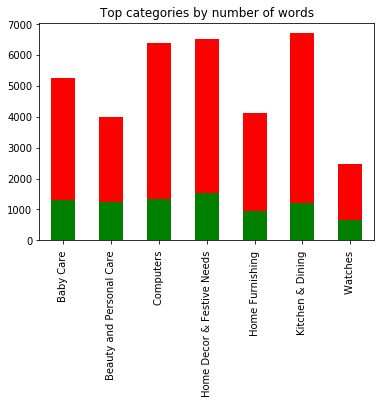

In [14]:
stemmer = EnglishStemmer()

tokenizer = nltk.RegexpTokenizer(r'\w+')

desc = defaultdict(list)

for i in data_text.index:
    token = tokenizer.tokenize(data_text.loc[i, 'description'].lower())
    desc[i] += [stemmer.stem(w) for w in token if not w in list(sw)]

stats, freq = dict(), dict()

for k, v in zip(desc.keys(), desc.values()):
    freq[k] = fq = nltk.FreqDist(v)
    stats[k] = {'total': len(v), 'Unique': len(fq.keys())}

df = pd.DataFrame.from_dict(stats, orient='index')

# freq display
df.sort_values(by='total', ascending=False)
df['total'].plot(kind='bar', color="red", title='Top categories by number of words', label='Total')
df['Unique'].plot(kind='bar', color="green", label='Unique')
plt.show()

## TF-IDF

In [15]:
data_tf = data.reset_index()[['categ', 'product_name', 'description']]

def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    tokens = nltk.word_tokenize(text)
    stems = stem_tokens(tokens, stemmer)
    return stems

token_dict = defaultdict(list)

for i in range(0, len(data_tf)):
    lowers = data_tf.loc[i,'description'].lower()
    no_punctuation = lowers.translate(string.punctuation)
    token_dict[i] = no_punctuation

tfIdf = TfidfVectorizer(tokenizer=tokenize, stop_words=sw)
values = tfIdf.fit_transform(token_dict.values())

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'s", 'abov', 'adapt', 'ani', 'babi', 'batteri', 'becaus', 'befor', 'ceram', 'coffe', 'content', 'could', 'deliveri', 'detail', 'dimens', 'discount', 'doe', 'dure', 'easi', 'featur', 'genuin', 'guarante', 'materi', 'might', 'must', "n't", 'need', 'onc', 'onli', 'onlin', 'ourselv', 'packag', 'qualiti', 'replac', 'sale', 'sha', 'ship', 'showpiec', 'specif', 'themselv', 'veri', 'warranti', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [16]:
X_embedded = TSNE(n_components=2).fit_transform(values)
X_embedded_df = pd.DataFrame(X_embedded, index=data_tf.index, columns=['V1', 'V2'])

In [17]:
data_tf_plot = pd.merge(data_tf, X_embedded_df,
                        left_index=True,
                        right_index=True,
                        how='inner')[['categ', 'V1', 'V2']]

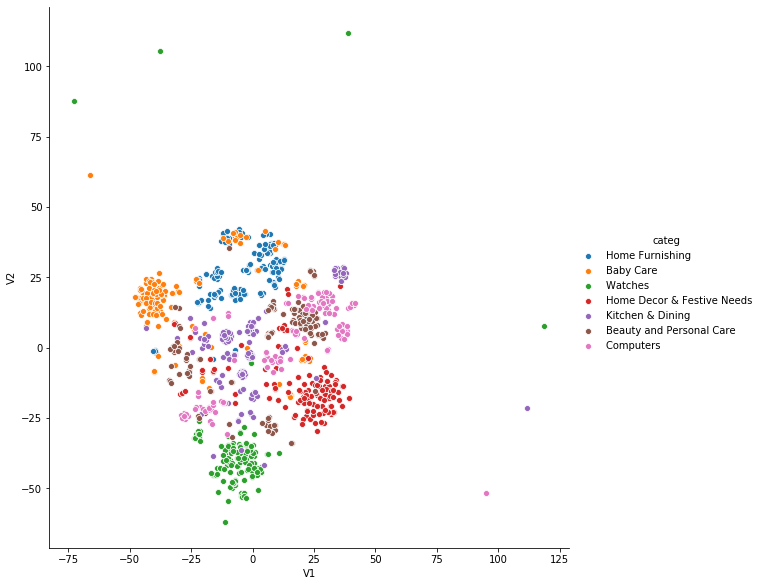

In [20]:
sns.pairplot(x_vars=['V1'], y_vars=['V2'], data=data_tf_plot, hue='categ', height=8)
plt.show()

# Classifier

In [84]:
np.random.seed(42)

## Train & Test

In [41]:
x = data_tf_plot[['V1', 'V2']]
y = data_tf_plot[['categ']]

In [42]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

## Cross-Validation

In [43]:
# Nombre d'arbres dans la forêt
n_estimators = [777]
# Level max des arbres
max_depth = [int(x) for x in np.linspace(60, 110, num = 11)]
max_depth.append(None)
# nombre de sample min pour split
min_samples_split = [2, 5]

# On crée la random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split}

In [44]:
t0 = time.perf_counter()

rf = RandomForestClassifier()

# On recherche avec 100 combinaisons différentes 
rf = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=100, 
                               cv=3, verbose=2, random_state=42, n_jobs=-1)

# On fit
rf.fit(x_train, y_train)

t1 = time.perf_counter()
print("\n")
print ('Function elapsed in: ', t1-t0, 's')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:281: UserWarning: The total space of parameters 24 is smaller than n_iter=100. Running 24 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:    8.4s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)




Function elapsed in:  9.481291400000146 s


In [45]:
rf.best_params_

{'n_estimators': 777, 'min_samples_split': 2, 'max_depth': 60}

In [51]:
t0 = time.perf_counter()

rf = RandomForestClassifier(n_estimators = 777, min_samples_split = 2, max_depth = 60, n_jobs = -1)
rf.fit(x_train, y_train)
# on prédit
y_predict = rf.predict(x_test)

t1 = time.perf_counter()
print("\n")
print ('Function elapsed in: ', t1-t0, 's')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.




Function elapsed in:  1.0163996999999654 s


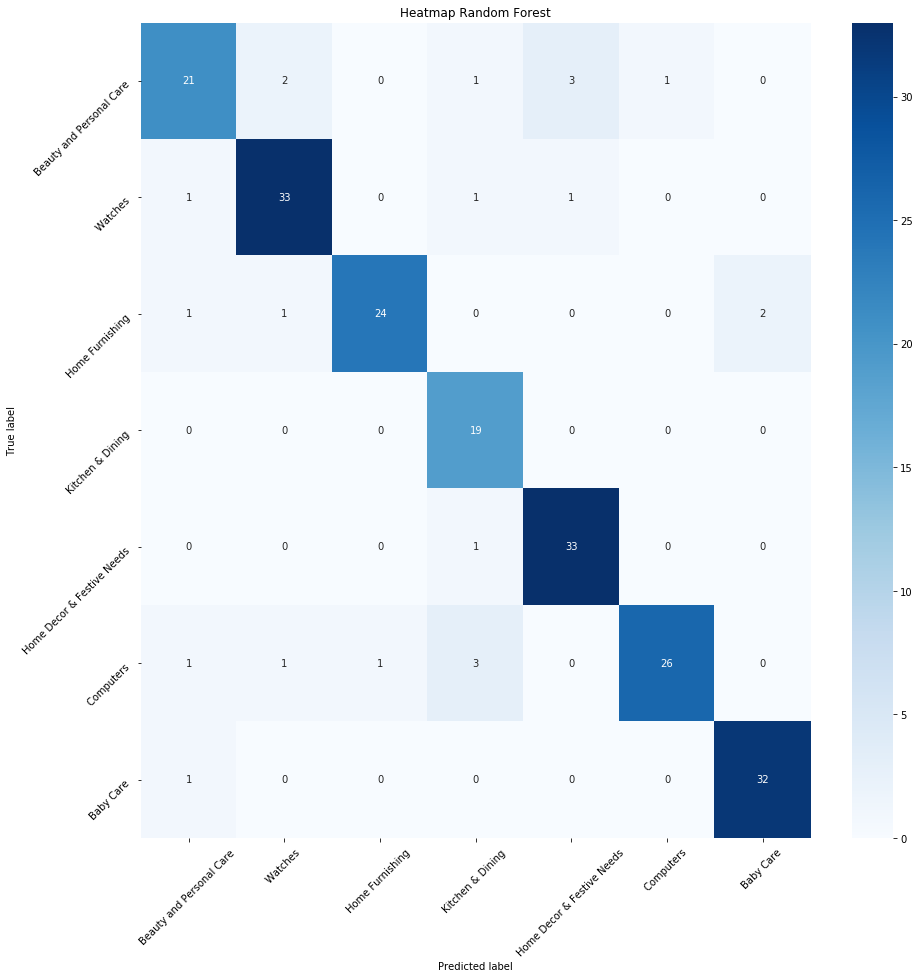

In [81]:
y_predict_df = pd.DataFrame(y_predict, index=y_test.index, columns=['Predict'])
accuracy = pd.merge(y_test, y_predict_df, left_index=True, right_index=True, how='inner')

conf_matrix = confusion_matrix(accuracy["categ"], 
                               accuracy['Predict'])

x_label = accuracy["categ"].unique()
y_label = accuracy["categ"].unique()

ax = plt.subplots(figsize=(15,15))
ax = sns.heatmap(conf_matrix, cmap=plt.cm.Blues, annot=True)
ax.set(xticklabels=x_label, yticklabels=y_label,
        title="Heatmap Random Forest",
        ylabel='True label',
        xlabel='Predicted label')
#plt.savefig("Graphiques/heatmap_kmeans")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()